In [1]:
from PIL import Image
import pandas as pd
import os
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import time
import copy

In [2]:
class ArtDataset(Dataset):
    def __init__(self,  csv_file, img_dir, transform=None): 
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.data_info = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data_info)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.img_dir,
                                self.data_info.iloc[idx, 0])
        
        image = Image.open(img_name).convert('RGB')
        
        a = np.asarray(image)
        #print(a.shape, img_name)
        label = self.data_info.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'label': label}
        return sample

### Test on the dataset

0 <PIL.Image.Image image mode=RGB size=224x224 at 0x12D950690>
1 <PIL.Image.Image image mode=RGB size=224x224 at 0x12DA2E250>
2 <PIL.Image.Image image mode=RGB size=224x224 at 0x12DB03210>


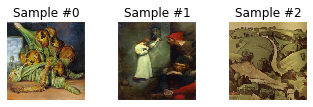

In [3]:
art_data_tensor = ArtDataset(csv_file = 'train_all_classes.csv', img_dir = 'train/', 
                     transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                          std=[0.229, 0.224, 0.225])]))


test_ds_pil = ArtDataset(csv_file = 'train_all_classes.csv', img_dir = 'train/', 
                     transform = transforms.Compose([transforms.Resize((224,224))]))
                                                    

#test_ds_pil = ArtDataset(csv_file = 'train_1_info.csv', img_dir = 'train_1/', 
                     #transform =None)
fig = plt.figure()

for i in range(3):
    sample = test_ds_pil[i]
    print(i, sample['image'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])
    
 

    

In [4]:
indicies = np.arange(len(art_data_tensor))
random.Random(148).shuffle(indicies)
split_index1 = int(len(art_data_tensor) * 0.68)
split_index2 = int(len(art_data_tensor) * 0.8)
subset_indices_train = indicies[:split_index1]
subset_indices_valid = indicies[split_index1:split_index2]
subset_indices_test = indicies[-split_index2:]
train_loader = torch.utils.data.DataLoader(art_data_tensor, batch_size=32,
                                           sampler=SubsetRandomSampler(subset_indices_train))
val_loader = torch.utils.data.DataLoader(art_data_tensor, batch_size=32,
                                         sampler=SubsetRandomSampler(subset_indices_valid))
test_loader = torch.utils.data.DataLoader(art_data_tensor, batch_size=32,
                                          sampler=SubsetRandomSampler(subset_indices_test))
data_sizes = {}
data_sizes['train'] = len(subset_indices_train)
data_sizes['val'] = len(subset_indices_valid)

In [5]:
def test(model, device, test_loader):
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    test_num = 0
    first_step = True
    with torch.no_grad():   # For the inference step, gradient is not computed
        cnt = 1
        print(len(test_loader))
        for x in test_loader:
            if cnt==10:
                break
            print(cnt)
            cnt+=1
            data = x['image']
            target = x['label']
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            indices = [i for i, x in enumerate(pred.eq(target.view_as(pred))) if x == False]
            test_num += len(data)

            if first_step:
                total_output = np.array(output)
                labels = np.array(target.view_as(pred))
            else:
                total_output = np.vstack((total_output, output))
                labels = np.vstack((labels, np.array(target.view_as(pred))))
            first_step = False

    test_loss /= test_num

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_num,
        100. * correct / test_num))
    
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

resnet18 = models.resnet18(pretrained=True)
#test(resnet18, device, test_loader)

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 5

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True


def train_model(model, dataloaders, data_sizes, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for x in dataloaders[phase]:   
                inputs = x['image']
                labels = x['label']
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #print(phase, preds-labels.data)
               

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]
            #print(phase, data_sizes[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = val_loader


print(data_sizes['train'])
print(data_sizes['val'])

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, data_sizes, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

39680
7003
Epoch 0/14
----------


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2731: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
